In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.metrics import mean_squared_error

import xgboost

import warnings
warnings.simplefilter('ignore')

In [21]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure",
       autolayout=True,
       figsize=(25,12),
       titlesize=18,
       titleweight='bold')

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

In [22]:
df_dict = pd.read_pickle(r'C:\Users\Y893263\POCM_python\syn_dict.pickle')

In [23]:
# April Actuals

f_870040 = 589105
f_870008 = 233759
f_870009 = 491376

In [24]:
df = df_dict['870009']
df.index = pd.to_datetime(df.index)
df = df[df.index != '2022-03-11'] # remove outlier
df = df[['amount']]
df = df.loc['2021':'2022']
cal_df = df.resample('D').sum()
bday_df = df.resample('B').sum()

In [25]:
# outlier
cal_df[cal_df['amount'] > 1000000]

,amount
post_date,


In [26]:
cal_df['Time_dummy'] = np.arange(len(cal_df.index))

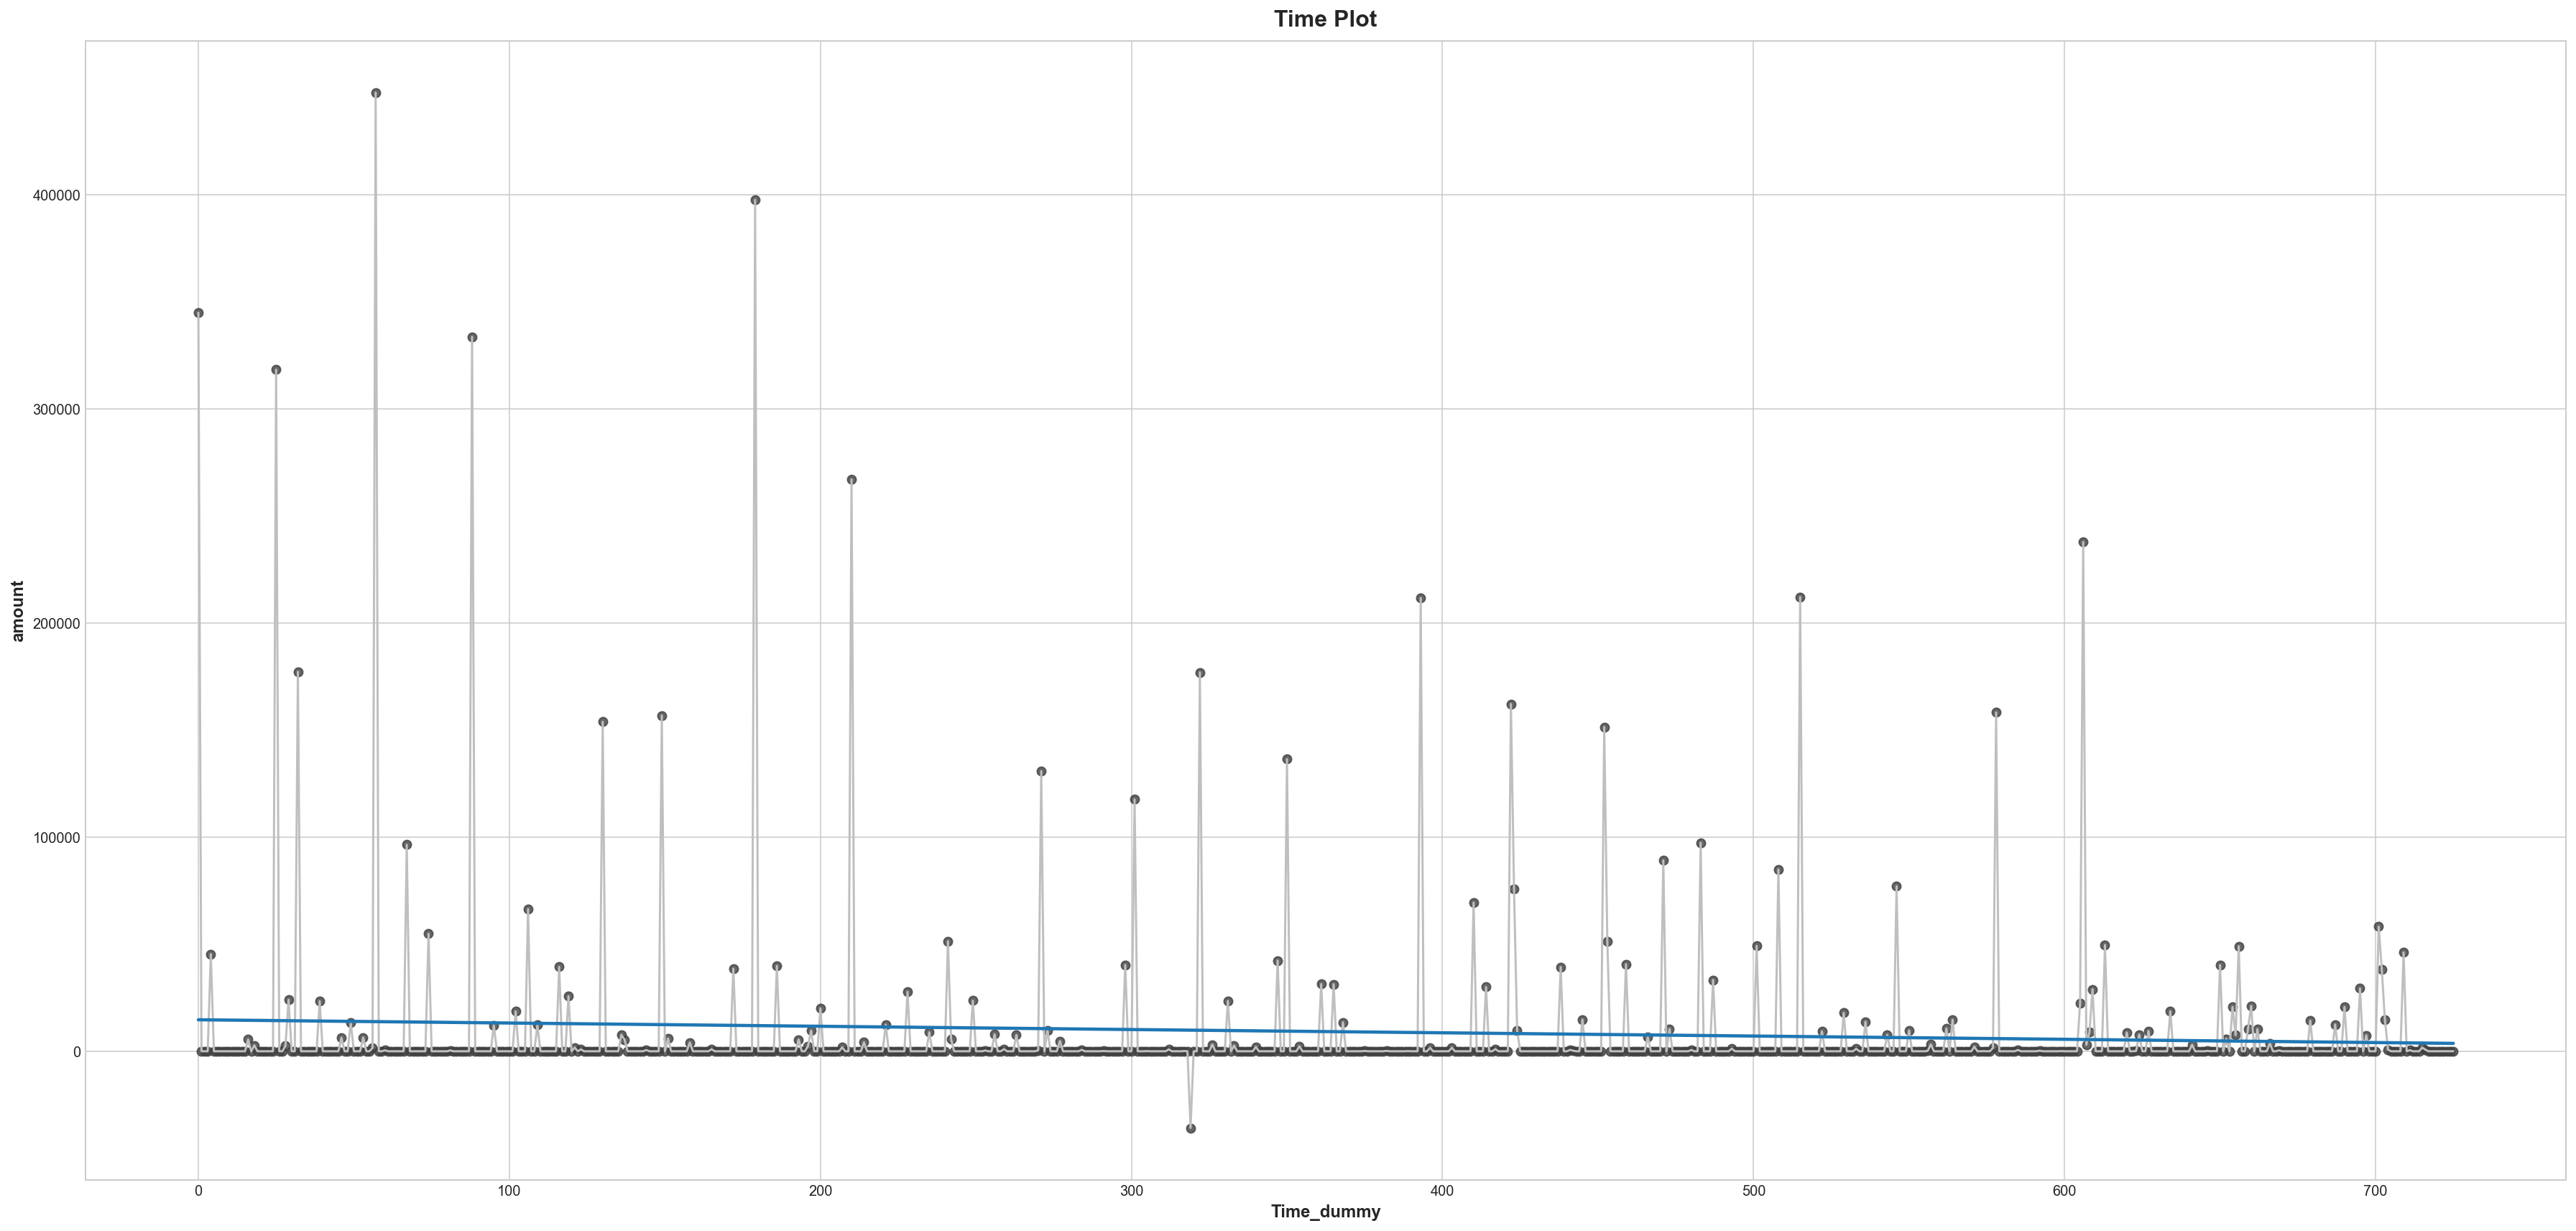

y = 14708.701 + -15.203x


In [27]:
fig, ax = plt.subplots()
ax.plot('Time_dummy', 'amount', data=cal_df, color='0.75')
ax = sns.regplot(x='Time_dummy', y='amount', data=cal_df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot')
plt.show()

import scipy

slope, intercept, r, p, sterr = scipy.stats.linregress(x= ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())

print('y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')


__No trend for this data, but keep for other data sets__

## Walk forward function

In [28]:
def walk_forward_op_datasets_return(df, target=None, start_date='2022-07-31', end_date='2022-12-31',
                                    test_start='2022-08-01', test_end='2022-08-30', freq='M',
                                    features=None):
    
    """This is good. Good job sticking with it"""
    
    beg_date = df.index[0].to_period('M').to_timestamp() # get first date in df ts index
    split_dates = [y.strftime('%Y-%m-%d') for y in pd.date_range(start=start_date, end=end_date, freq=freq)] # get end date of test data split; changes dtype to strings
    train_beg_split = pd.date_range(start=beg_date, periods=len(split_dates)-1, freq='MS') # creates beginning of train data split
    test_beg_split = pd.date_range(start=test_start, periods=len(split_dates)-1, freq='MS') # creates beginning of test data split
    test_end_split = pd.date_range(start=test_end, periods=len(split_dates)-1, freq='M') # creates end of test data split
    
    if target is not None:
        for train_beg, train_end, test_beg, test_end in zip(train_beg_split, split_dates, test_beg_split, test_end_split):
            X_train, y_train = df[train_beg:train_end].loc[:, df.columns != target], df[train_beg:train_end][target] 
            X_test, y_test = df[test_beg:test_end].loc[:, df.columns != target], df[test_beg:test_end][target]
            yield X_train, y_train, X_test, y_test
    
    else:
        for train_beg, train_end, test_beg, test_end in zip(train_beg_split, split_dates, test_beg_split, test_end_split):
            X_train, y_train = df[train_beg:train_end], df[train_beg:train_end] 
            X_test, y_test = df[test_beg:test_end], df[test_beg:test_end]
            yield X_train, y_train, X_test, y_test


In [29]:
# test_df = create_features(cal_df)
# for a, b, c, d in walk_forward_op_datasets_return(test_df, 'amount'):
#     print(a.shape,b.shape, c.shape, d.shape)

## Create Features

In [30]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

## Baseline

In [31]:
def baseline(df, month_test: str, gr_adj = 1):
    gr_adj = gr_adj
    
    # get trend YoY
    trend = df.loc['2022']['amount'].sum() / df.loc['2021']['amount'].sum()
    
    # adjust PY's number by trend
    py_month = df.loc['2021'+'-'+str(month_test)].sum()/trend
    avg_monthly = (py_month + df.loc['2022'+'-'+str(month_test)].sum()) / 2
    trend_min_1 = trend - 1
    value = avg_monthly * (1 + (trend_min_1 * gr_adj))
    
    return value, avg_monthly, trend_min_1

In [32]:
cal_df = cal_df[['amount']]
# cal_df['amount_feature'] = cal_df['amount']

In [33]:
april_base = baseline(cal_df, '04')

In [34]:
april_base

(amount    355389.436625
 dtype: float64,
 amount    545261.075485
 dtype: float64,
 -0.3482215169894872)

In [35]:
test_df = create_features(cal_df)
test_df.head()

,amount,dayofweek,quarter,month,year,dayofyear,dayofmonth
post_date,,,,,,,
2021-01-04,344941.93,0,1,1,2021,4,4
2021-01-05,0.00,1,1,1,2021,5,5
2021-01-06,0.00,2,1,1,2021,6,6
2021-01-07,0.00,3,1,1,2021,7,7
2021-01-08,45377.28,4,1,1,2021,8,8


## Try different Algos

In [36]:
# set this up to accept an algo of choice???
def run_xbg_algo(df, target=None):
    metrics = []
    df = df
    for X_train, y_train, X_test, y_test in walk_forward_op_datasets_return(df, target):
        xgb = xgboost.XGBRegressor(n_estimators=1000,
                                  objective='reg:squarederror',
                                  learning_rate=0.01)
        xgb.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100,
                early_stopping_rounds=100)
        
        y_fit = pd.DataFrame(xgb.predict(X_train), index=y_train.index, )
        y_pred = pd.DataFrame(xgb.predict(X_test), index=y_test.index, )
        print(f"shapes: {X_train.shape, X_test.shape, y_train.shape, y_test.shape}")
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        print(f"rmse: {rmse}")
        metrics.append(rmse)
        
    return sum(metrics) / len(metrics), y_pred.sum(), y_test.sum()

In [37]:
run_xbg_algo(test_df, target='amount')

[0]	validation_0-rmse:44563.03516	validation_1-rmse:28406.98633
[100]	validation_0-rmse:28113.35547	validation_1-rmse:29697.92383
[117]	validation_0-rmse:26592.19531	validation_1-rmse:30417.38672
shapes: ((574, 6), (31, 6), (574,), (31,))
rmse: 28302.59184789624
[0]	validation_0-rmse:40440.24219	validation_1-rmse:45109.45312
[100]	validation_0-rmse:23694.42969	validation_1-rmse:44717.42578
[160]	validation_0-rmse:18594.37891	validation_1-rmse:44799.82422
shapes: ((577, 6), (30, 6), (577,), (30,))
rmse: 44660.31665090624
[0]	validation_0-rmse:40964.80469	validation_1-rmse:12976.26953
[100]	validation_0-rmse:23828.72461	validation_1-rmse:20585.16016
shapes: ((579, 6), (31, 6), (579,), (31,))
rmse: 12975.125221328812
[0]	validation_0-rmse:36403.51953	validation_1-rmse:7402.38086
[100]	validation_0-rmse:21929.57031	validation_1-rmse:16739.05273
[102]	validation_0-rmse:21736.39258	validation_1-rmse:16975.06250
shapes: ((579, 6), (30, 6), (579,), (30,))
rmse: 7318.960633126513
[0]	validation

(21736.371593341733,
 0    39074.609375
 dtype: float32,
 168603.13)

In [38]:
run_xbg_algo(cal_df)

[0]	validation_0-rmse:44435.76172	validation_1-rmse:28152.40625
[100]	validation_0-rmse:19356.32227	validation_1-rmse:10413.61133
[200]	validation_0-rmse:9045.05566	validation_1-rmse:4522.64795
[300]	validation_0-rmse:4533.16406	validation_1-rmse:2048.16284
[400]	validation_0-rmse:2491.77026	validation_1-rmse:947.51642
[500]	validation_0-rmse:1436.18152	validation_1-rmse:539.37457
[600]	validation_0-rmse:850.54962	validation_1-rmse:370.35544
[700]	validation_0-rmse:509.63611	validation_1-rmse:302.99869
[800]	validation_0-rmse:307.31195	validation_1-rmse:273.19827
[900]	validation_0-rmse:185.80753	validation_1-rmse:263.26968
[999]	validation_0-rmse:113.03701	validation_1-rmse:258.20239
shapes: ((574, 1), (31, 1), (574, 1), (31, 1))
rmse: 258.2015017919293
[0]	validation_0-rmse:40359.64062	validation_1-rmse:44616.39062
[100]	validation_0-rmse:18118.58398	validation_1-rmse:22062.20898
[200]	validation_0-rmse:8642.40820	validation_1-rmse:12260.40820
[300]	validation_0-rmse:4402.21777	valid

(1334.5691739405859,
 0    164939.46875
 dtype: float32,
 amount    168603.13
 dtype: float64)

# Predictions

In [39]:
# bring in updated syncada data; only using basic data--can add time variables later

sys.path.insert(0, r'C:\Users\Y893263\Python_snowflake')
import snowflake_connect
import sqlite_connect

In [40]:
sql_query = """
SELECT 
  EXTRACT (YEAR FROM gl.DOC_POST_DT) AS sap_post_year,
  gl.FISCL_YR_MO_NBR AS fiscal_year,
  gl.BUS_AREA_CD as bus_area,
  gl.CMPY_CD as company_code,
  coa.COST_CNTR_WO_ZEROS_CD AS cost_center,
  coa.COST_CNTR_NM cost_center_name,
  coa.COST_ELEM_WO_ZEROS_CD AS cost_element,
  coa.COST_ELEM_NM AS cost_element_name,
  gl.LCL_CRNCY_DBT_CR_AMT AS amount,
  gl.ACCTG_DOC_TYP_CD AS doc_type,
  gl.ORD_NBR AS Internal_order, 
  gl.DOC_POST_DT as post_date
FROM ABI_WH.EDW.GL_LN_ITEM gl
JOIN ABI_WH.EDW.COA_RPT_XREF coa
ON (gl.COST_CNTR_CD = coa.COST_CNTR_CD AND gl.GL_ACCT_NBR = coa.COST_ELEM_CD)
WHERE cost_element IN ('870008', '870009', '870040')
AND (cost_center = '1220000053')
AND (gl.FISCL_YR_MO_NBR BETWEEN 2020001 AND to_number(to_char(current_date, 'YYYYMMDD')))

;
"""

In [41]:
df_freight = snowflake_connect.snowflake_connection(sql_query=sql_query)
df_freight = df_freight.rename(columns=str.lower)
df_freight['post_date'] = pd.to_datetime(df_freight['post_date'])
df_freight = df_freight.set_index('post_date')

opening...
Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [42]:
df_f = df_freight.copy()

In [43]:
# clean data for prediction
df_f = df_f['2021-03':'2023-03']
df_f = df_f[(df_f['cost_element'].str.contains('870009')) & (df_f['doc_type'].str.contains('KT'))]
df_f = df_f[['amount']]
# make amount its own feature
df_f['target_feature'] = df_f['amount']
df_f = df_f.resample('D').sum()

In [44]:
df_f.head()

,amount,target_feature
post_date,,
2021-03-01,1603.01,1603.01
2021-03-02,447713.06,447713.06
2021-03-03,0.00,0.00
2021-03-04,0.00,0.00
2021-03-05,465.37,465.37


In [45]:
# run best algo from above

FEATURES = ['target_feature']
TARGET = 'amount'


X_all = df_f[FEATURES]
y_all = df_f[TARGET]

# Train on all data

# look at walkforward for n_estimators to use
xgb = xgboost.XGBRegressor(n_estimators=500,
                           objective='reg:squarederror',
                           learning_rate=0.01)

xgb.fit(X_all, y_all,
        eval_set = [(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:54288.19141
[100]	validation_0-rmse:29252.54297
[200]	validation_0-rmse:16681.97852
[300]	validation_0-rmse:9830.74023
[400]	validation_0-rmse:5876.76660
[499]	validation_0-rmse:3557.28809


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Future blank df

In [55]:
index = pd.date_range(start='2023-04-01', end='2023-04-30', freq='D')
future_df = pd.DataFrame(index=index)
future_df['Future'] = True
df_f['Future'] = False
df_and_fut = pd.concat([df_f, future_df])

In [56]:
df_and_fut.head()

,amount,target_feature,Future
2021-03-01,1603.01,1603.01,False
2021-03-02,447713.06,447713.06,False
2021-03-03,0.00,0.00,False
2021-03-04,0.00,0.00,False
2021-03-05,465.37,465.37,False


In [57]:
future_w_features = df_and_fut.query('Future').copy()

In [58]:
future_w_features.head()

,amount,target_feature,Future
2023-04-01,NaN,NaN,True
2023-04-02,NaN,NaN,True
2023-04-03,NaN,NaN,True
2023-04-04,NaN,NaN,True
2023-04-05,NaN,NaN,True


In [59]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 761 entries, 2021-03-01 to 2023-03-31
Freq: D
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   amount          761 non-null    float64
 1   target_feature  761 non-null    float64
 2   Future          761 non-null    bool   
dtypes: bool(1), float64(2)
memory usage: 18.6 KB


In [60]:
future_w_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2023-04-01 to 2023-04-30
Freq: D
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   amount          0 non-null      float64
 1   target_feature  0 non-null      float64
 2   Future          30 non-null     bool   
dtypes: bool(1), float64(2)
memory usage: 750.0 bytes


In [61]:
future_w_features['pred'] = xgb.predict(future_w_features['amount'])

ValueError: training data did not have the following fields: target_feature

In [62]:
df_f['amount']

post_date
2021-03-01      1603.01
2021-03-02    447713.06
2021-03-03         0.00
2021-03-04         0.00
2021-03-05       465.37
                ...    
2023-03-27     21466.84
2023-03-28         0.00
2023-03-29         0.00
2023-03-30         0.00
2023-03-31     14798.05
Freq: D, Name: amount, Length: 761, dtype: float64

In [ ]:
# compare to actuals and get $ diff and look at rmse error metric

In [ ]:
future_w_features['amount']